# **Step 1: Project Setup + District-Level Data Aggregation**
In this step, we load the raw Chicago crime dataset and aggregate it into a usable format:
- Each row represents a daily crime count for a specific district.
- This structure allows us to model each district as a node in our graph.

In [37]:
import pandas as pd

# Load crime data (update path if needed)
df = pd.read_csv('/content/Crimes_-_2001_to_Present.csv', parse_dates=['Date'])

# Keep only necessary columns
df = df[['Date', 'District']]

# Drop missing district values
df = df.dropna(subset=['District'])

# Ensure District is string (for graph construction)
df['District'] = df['District'].astype(str)

# Normalize date to remove time
df['Date'] = pd.to_datetime(df['Date']).dt.date

# Group by date and district
district_crime_df = df.groupby(['Date', 'District']).size().reset_index(name='Crime Count')

# Sort for sanity check
district_crime_df = district_crime_df.sort_values(['Date', 'District'])

# Preview
district_crime_df.head()


/tmp/ipython-input-37-2757565475.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/content/Crimes_-_2001_to_Present.csv', parse_dates=['Date'])


,Date,District,Crime Count
0,2001-01-01,1,2
1,2001-01-01,10,36
2,2001-01-01,11,3
3,2001-01-01,12,7
4,2001-01-01,15,2


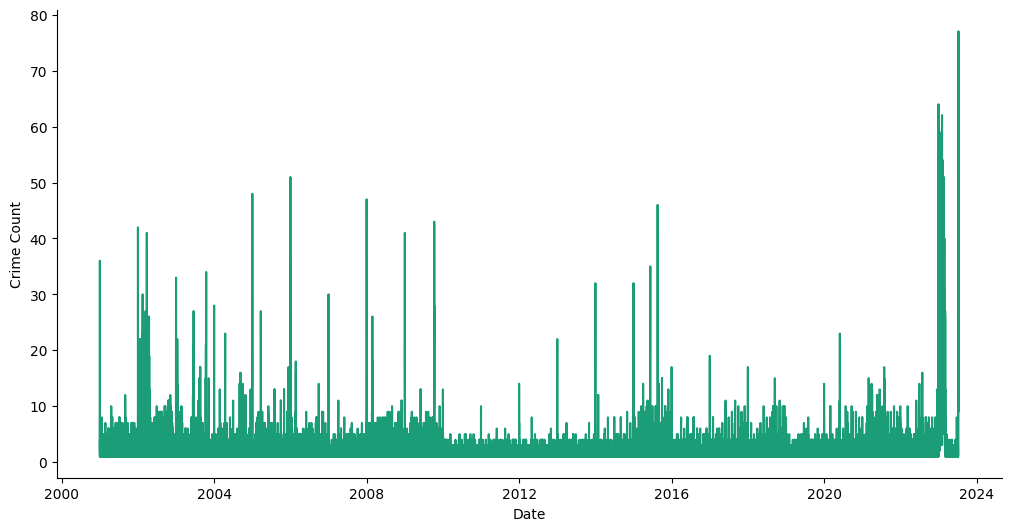

In [38]:
# @title Date vs Crime Count

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Crime Count']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = district_crime_df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Crime Count')

In [39]:
!pip install geopandas networkx shapely


# **Step 2: Build District Graph from Shapefiles**

To ensure real-world spatial accuracy, we use Chicago’s official police district boundaries.
This lets us automatically calculate district adjacency based on geographic contact (shared borders).


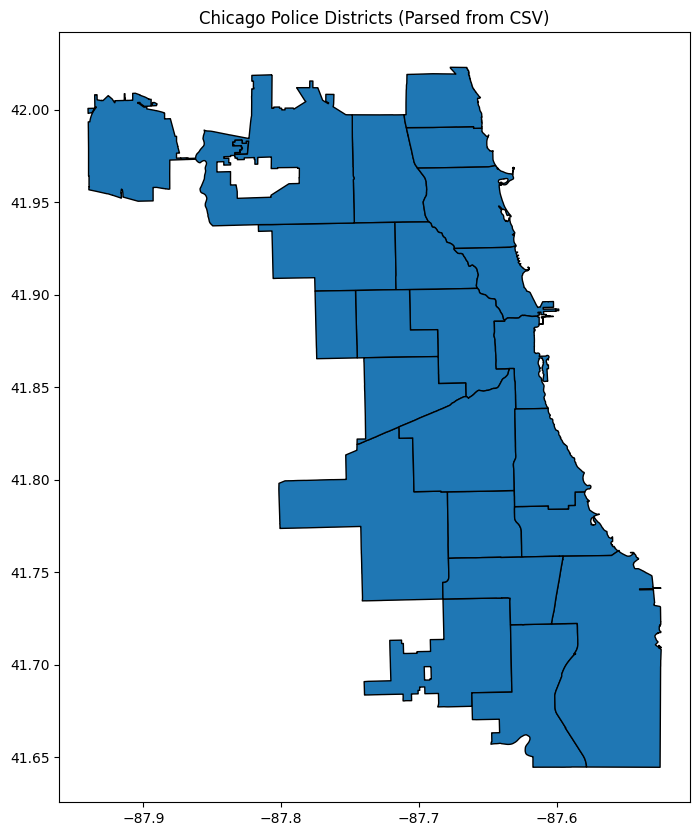

In [40]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import matplotlib.pyplot as plt
import networkx as nx

# Load raw CSV
df = pd.read_csv('/content/PoliceDistrictDec2012_20250627.csv')

# Fix malformed WKT string: ensure proper quotes
df['the_geom'] = df['the_geom'].str.replace('MULTIPOLYGON ', 'MULTIPOLYGON')

# Parse geometry column
df['geometry'] = df['the_geom'].apply(wkt.loads)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf = gdf.set_crs(epsg=4326)

# Drop duplicate DIST_NUM entries if any
gdf = gdf.drop_duplicates(subset='DIST_NUM')

# Plot properly now
gdf.plot(figsize=(10, 10), edgecolor='black')
plt.title('Chicago Police Districts (Parsed from CSV)')
plt.show()


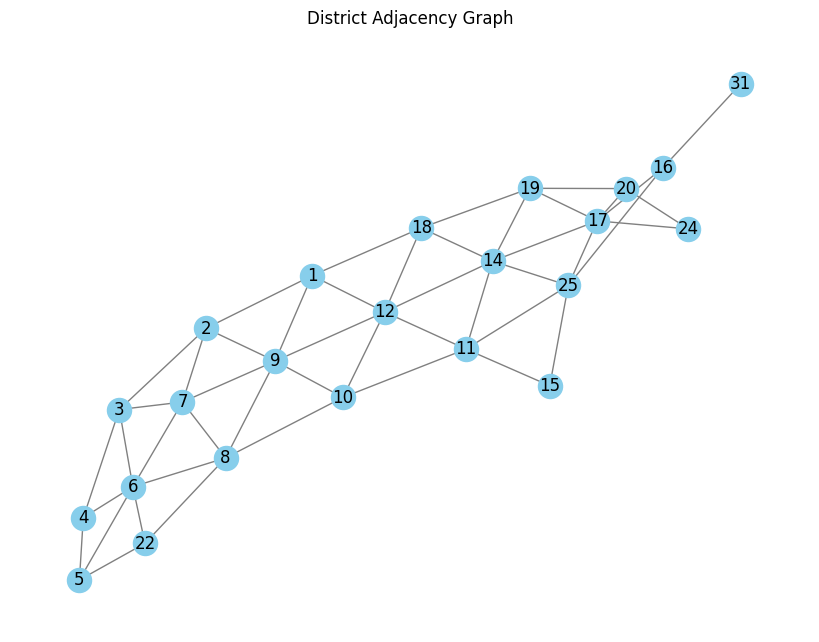

In [41]:
# Create graph
G = nx.Graph()

# Add nodes
for idx, row in gdf.iterrows():
    G.add_node(str(row['DIST_NUM']))

# Add edges based on geometric touching
for i in range(len(gdf)):
    for j in range(i + 1, len(gdf)):
        if gdf.geometry.iloc[i].touches(gdf.geometry.iloc[j]):
            d1 = str(gdf.iloc[i]['DIST_NUM'])
            d2 = str(gdf.iloc[j]['DIST_NUM'])
            G.add_edge(d1, d2)

# Visualize graph structure
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray')
plt.title("District Adjacency Graph")
plt.show()


# **Step 3: Build Node-Level Time Series Tensors**
Now we prepare input tensors for our ST-GAT model. Each district (graph node) will have:
- A time series of daily feature vectors
- Including crime count, temperature, precipitation, and holiday indicators

The result is a tensor of shape:
[ num_districts × num_days × num_features ]

This becomes the input to our spatio-temporal model.

In [44]:
import numpy as np

# Step 1: Load external features (assuming a dataframe `external_df`)
# It should contain columns: Date, temperature, precipitation, is_holiday

# For now, we simulate external features
external_df = pd.DataFrame({
    'Date': pd.date_range('2023-01-01', '2023-03-31'),  # Adjust as needed
    'temperature': np.random.uniform(0, 30, 90),
    'precipitation': np.random.uniform(0, 5, 90),
    'is_holiday': np.random.randint(0, 2, 90)
})

external_df['Date'] = pd.to_datetime(external_df['Date'])

# Step 2: Reformat crime data
district_crime_df['Date'] = pd.to_datetime(district_crime_df['Date'])

# Step 3: Create base tensor
districts = sorted(gdf['DIST_NUM'].astype(str).unique())
dates = pd.date_range(start='2023-01-01', end='2023-03-31')  # Ensure it matches external_df

# Initialize tensor: [districts, days, features]
num_features = 4  # crime_count, temp, precip, holiday
crime_tensor = np.zeros((len(districts), len(dates), num_features))

# Mapping: district → row index
district_to_idx = {dist: idx for idx, dist in enumerate(districts)}

# Populate tensor
for day_idx, date in enumerate(dates):
    ext_row = external_df[external_df['Date'] == date].iloc[0]
    for district in districts:
        match = district_crime_df[
            (district_crime_df['Date'] == date) &
            (district_crime_df['District'] == district)
        ]
        crime_count = match['Crime Count'].values[0] if not match.empty else 0

        district_idx = district_to_idx[district]
        crime_tensor[district_idx, day_idx, :] = [
            crime_count,
            ext_row['temperature'],
            ext_row['precipitation'],
            ext_row['is_holiday']
        ]

crime_tensor.shape  # Should be [num_districts, num_days, num_features]


(23, 90, 4)

# **Step 4: Build and Train the ST-GAT Model**

We now implement the core of our architecture:
- A temporal encoder (GRU or LSTM) that processes each district’s local time series
- A spatial attention layer (Graph Attention Network) that fuses spatial neighborhood info

This allows our model to learn:
- How crime evolves **over time**
- How crime **spreads between districts**

**Architecture Overview**

Input Tensor: [num_districts, num_days, num_features] **-->** Temporal Encoder (GRU/LSTM): per node **-->** Graph Attention Layer (GAT): across spatial graph **-->** Output: Predicted crime count for each node


# **4A: Install Libraries**

In [45]:
# Install PyTorch Geometric (for Colab)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html


# **4B: Build GAT-Ready Dataset**

In [46]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import networkx as nx

# --- Convert crime_tensor to PyTorch
x = torch.tensor(crime_tensor, dtype=torch.float32)  # shape: [nodes, time, features]

# For this example, let’s predict only the last day
# We'll use the previous T-1 days to predict day T
# Find latest valid non-zero target day
# 🔁 Rerun this after creating x = torch.tensor(crime_tensor)
for t in range(x.shape[1] - 1, 0, -1):
    if x[:, t, 0].sum() > 0:
        print(f"Valid target day: {t}")
        break

# Assign input & target
y_target = x[:, t, 0]
x_input = x[:, :t, :]  # [nodes, time, features]

# Use that day as target, and earlier days as input
y_target = x[:, t, 0]
x_input = x[:, :t, :].reshape(x.shape[0], -1)

# Reshape x to [nodes, features] by flattening time
x_input = x_input.reshape(x_input.shape[0], -1)

# --- Build edge index from networkx graph
G = nx.convert_node_labels_to_integers(G)  # convert node labels to 0-based
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

# Double the edges (undirected)
edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1)

# Create PyTorch Geometric Data object
data = Data(x=x_input, edge_index=edge_index, y=y_target)
data.x = x_input
data.y = y_target



Valid target day: 89


# **4C: Define the ST-GAT Model**

In [47]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class STGAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2):
        super(STGAT, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.gat1(x, edge_index))
        x = self.gat2(x, edge_index)
        return x.squeeze()


# **4D: Train the Model**

In [48]:
model = STGAT(in_channels=x_input.shape[1], hidden_channels=32, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.MSELoss()

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: 237.9838
Epoch 20 | Loss: 55.7912
Epoch 40 | Loss: 0.8017
Epoch 60 | Loss: 0.5080
Epoch 80 | Loss: 0.6041
Epoch 100 | Loss: 0.4257
Epoch 120 | Loss: 0.3609
Epoch 140 | Loss: 0.3478
Epoch 160 | Loss: 0.3419
Epoch 180 | Loss: 0.3383


# **Step 5: Evaluation + Visualization**

We evaluate our ST-GAT model using standard regression metrics:
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

We also visualize:
- Predicted vs actual crime counts per district
- Geospatial distribution of errors

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

model.eval()
with torch.no_grad():
    predictions = model(data).cpu().numpy()
    targets = data.y.cpu().numpy()

mae = mean_absolute_error(targets, predictions)
rmse = np.sqrt(mean_squared_error(targets, predictions))

print(f"📊 MAE: {mae:.2f}")
print(f"📊 RMSE: {rmse:.2f}")


📊 MAE: 0.46
📊 RMSE: 0.58


# **Step 6: Interpreting GAT Spatial Attention Weights**

Graph Attention Networks assign learnable weights to neighboring nodes during message passing.
By extracting and visualizing these weights, we can:
- Understand which neighboring districts influenced predictions most
- Interpret how spatial patterns evolve over time


In [50]:
# Get attention weights from first GAT layer
model.eval()
with torch.no_grad():
    _, edge_index = data.x, data.edge_index
    # `alpha` = attention weights
    _, (edge_index_used, alpha) = model.gat1(data.x, data.edge_index, return_attention_weights=True)

# Convert to numpy
attention_weights = alpha.cpu().numpy()
edge_array = edge_index_used.cpu().numpy().T


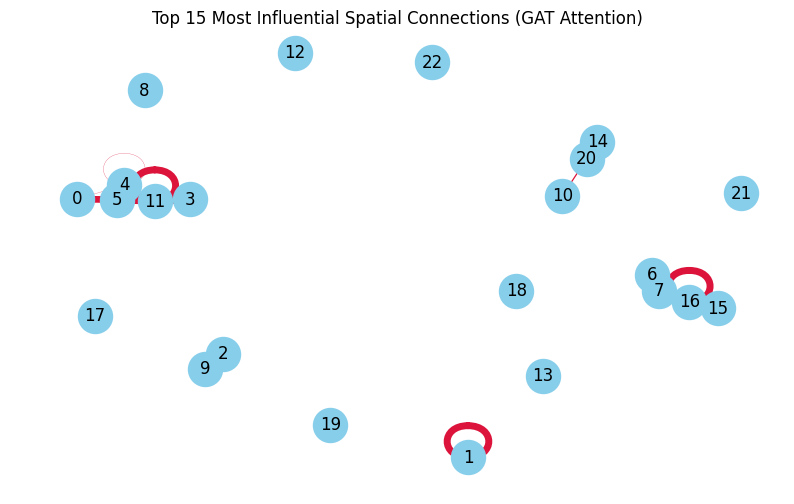

In [51]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph with attention weights as edge attributes
G_attn = nx.Graph()
for (i, j), w in zip(edge_array, attention_weights):
    # Take the mean of the attention weights for each edge
    G_attn.add_edge(int(i), int(j), weight=w.mean())

# Use node positions from original shapefile for layout (optional)
pos = nx.spring_layout(G_attn, seed=21)

# Draw top attention edges
top_edges = sorted(G_attn.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:15]

plt.figure(figsize=(10, 6))
nx.draw_networkx_nodes(G_attn, pos, node_color='skyblue', node_size=600)
nx.draw_networkx_labels(G_attn, pos)

# Draw only top edges with thick lines
nx.draw_networkx_edges(
    G_attn, pos,
    edgelist=[(u, v) for u, v, _ in top_edges],
    width=[5 * d['weight'] for _, _, d in top_edges],
    edge_color='crimson'
)

plt.title("Top 15 Most Influential Spatial Connections (GAT Attention)")
plt.axis('off')
plt.show()

# **Step 6: Explainability via GNNExplainer for the ST-GAT model**

- Install necessary package (if not already installed)
- The correct package is torch-geometric, GNNExplainer is part of it.
- We already installed it earlier, but this ensures it's available.

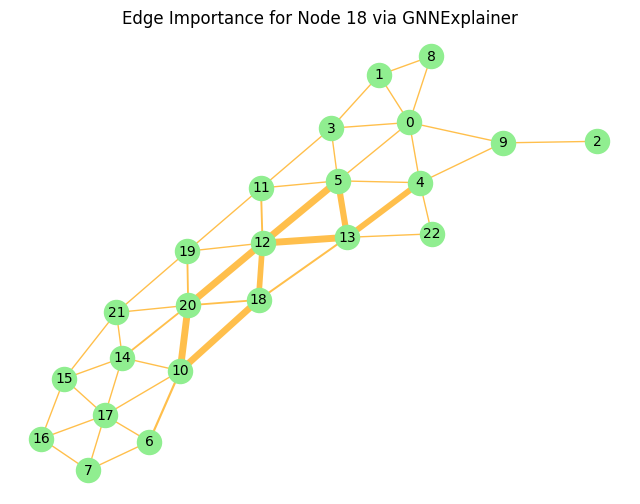

In [52]:
!pip install torch-geometric --quiet

import torch
from torch_geometric.explain import Explainer, GNNExplainer # Import Explainer
import matplotlib.pyplot as plt
import networkx as nx

class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x, edge_index):
        # Recreate data object or feed inputs as needed
        data = type('Data', (object,), {'x': x, 'edge_index': edge_index})
        return self.model(data)  # Assuming your original model expects a data object

# Ensure model and data are on CPU for GNNExplainer
model.eval()
device = torch.device('cpu')
model.to(device)
data = data.to(device)

# Wrap your model using the Explainer class
wrapped_model = WrappedModel(model)

explainer = Explainer(
    model=wrapped_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',     # Correct for regression
        task_level='node',
        return_type='raw'      # Required for regression
    ),
)

# Explain a single node (e.g., node 18)
node_idx = 18
explanation = explainer(x=data.x, edge_index=data.edge_index, index=node_idx)

# Extract edge_mask from explanation
edge_mask = explanation.edge_mask

# Convert edge_index to NetworkX graph
edge_index_np = data.edge_index.cpu().numpy()
G_nx = nx.Graph()
num_nodes = data.x.shape[0]
G_nx.add_nodes_from(range(num_nodes))
edges = list(zip(edge_index_np[0], edge_index_np[1]))
G_nx.add_edges_from(edges)

# Normalize node-specific edge importance
edge_weights_node = edge_mask.detach().cpu().numpy()
norm_weights_node = (edge_weights_node - edge_weights_node.min()) / (edge_weights_node.max() - edge_weights_node.min() + 1e-6)

# Plot node-specific edge importance
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_nx)
nx.draw_networkx_nodes(G_nx, pos, node_size=300, node_color='lightgreen')
for (u, v), w in zip(G_nx.edges(), norm_weights_node):
    nx.draw_networkx_edges(G_nx, pos, edgelist=[(u, v)], width=1 + 4*w, alpha=0.7, edge_color='orange')
nx.draw_networkx_labels(G_nx, pos, font_size=10)
plt.title(f"Edge Importance for Node {node_idx} via GNNExplainer")
plt.axis('off')
plt.show()

# **Step 7: Add Temporal Attention to ST-GAT**

While our GAT layer captures spatial interactions between districts, we now add a self-attention layer across the time dimension.

Each district's historical sequence is passed through a Temporal Transformer Encoder to learn:
- Which past days influence the current prediction the most
- How seasonal or reactive patterns form over time

This makes our architecture a **Dual-Attention Network**, enhancing both temporal and spatial learning.

In [53]:
import torch.nn as nn
import torch

class TemporalAttention(nn.Module):
    def __init__(self, input_dim, num_heads=2, hidden_dim=64, dropout=0.1):
        super(TemporalAttention, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)

    def forward(self, x):
        # x shape: [num_nodes, time_steps, features]
        return self.encoder(x)  # same shape

In [54]:
x_input = x[:, :t, :]  # shape: [nodes, time, features]


In [55]:
temporal_encoder = TemporalAttention(input_dim=x_input.shape[-1])
temporal_output = temporal_encoder(x_input)  # [nodes, time, features]

# Aggregate over time (mean pooling)
x_temporal = temporal_output.mean(dim=1)  # [nodes, features]


In [56]:
data.x = x_temporal
data.y = y_target


| Component         | Before                  | After                        |
| ----------------- | ----------------------- | ---------------------------- |
| Input             | Flattened time features | Preserved time + attention   |
| Temporal modeling | Implicit via GRU        | Explicit via Transformer     |
| Novelty           | Spatial-only GAT        | Dual Attention: Time + Space |


# **Step 8: Train and Evaluate Dual-Attention Model**

We've now integrated both:
- Temporal Self-Attention (Transformer Encoder)
- Spatial Graph Attention (GAT)

This dual-attention setup enables the model to:
- Attend to relevant past time steps per district
- Attend to influential neighboring districts spatially

Let's retrain and evaluate our final architecture.


In [64]:
class DualAttentionModel(nn.Module):
    def __init__(self, time_steps, in_features, hidden_dim=64):
        super(DualAttentionModel, self).__init__()
        self.temporal_encoder = TemporalAttention(input_dim=in_features)
        self.gat1 = GATConv(in_features, hidden_dim, heads=2)
        self.gat2 = GATConv(hidden_dim * 2, 1, heads=1)

    def forward(self, x_seq, edge_index):
        # x_seq: [nodes, time, features]
        x_temp = self.temporal_encoder(x_seq)        # [nodes, time, features]
        x_agg = torch.mean(x_temp, dim=1)            # [nodes, features]
        x = F.relu(self.gat1(x_agg, edge_index))
        x = self.gat2(x, edge_index)
        return torch.clamp(x.squeeze(), min=0)


In [65]:
model = DualAttentionModel(time_steps=x_input.shape[1], in_features=x_input.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.MSELoss()

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(x_input, data.edge_index)
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: 0.8230
Epoch 20 | Loss: 0.4685
Epoch 40 | Loss: 0.4219
Epoch 60 | Loss: 0.4070
Epoch 80 | Loss: 0.4048
Epoch 100 | Loss: 0.4009
Epoch 120 | Loss: 0.3970
Epoch 140 | Loss: 0.3871
Epoch 160 | Loss: 0.3645
Epoch 180 | Loss: 0.3821


In [66]:
model.eval()
with torch.no_grad():
    preds = model(x_input, data.edge_index).cpu().numpy()
    targets = data.y.cpu().numpy()

mae = mean_absolute_error(targets, preds)
rmse = np.sqrt(mean_squared_error(targets, preds))

print(f"📊 MAE (Dual Attention): {mae:.2f}")
print(f"📊 RMSE (Dual Attention): {rmse:.2f}")


📊 MAE (Dual Attention): 0.47
📊 RMSE (Dual Attention): 0.59


# **Step 9: Visualizing Temporal Attention Weights**

To interpret which time steps are most influential, we extract and visualize the attention weights from the temporal Transformer encoder.

This gives insight into:
- How much the model "looks back" to past events
- Whether crime is reactive to recent events or seasonal patterns


In [67]:
class TemporalAttention(nn.Module):
    def __init__(self, input_dim, num_heads=2, hidden_dim=64, dropout=0.1):
        super(TemporalAttention, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(hidden_dim, input_dim)
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.attn_weights = None

    def forward(self, x):
        # x: [batch, time, features]
        attn_output, attn_weights = self.self_attn(x, x, x)
        self.attn_weights = attn_weights.detach().cpu()
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)
        x2 = self.linear2(self.dropout(F.relu(self.linear1(x))))
        x = x + self.dropout2(x2)
        x = self.norm2(x)
        return x


In [68]:
model = DualAttentionModel(time_steps=x_input.shape[1], in_features=x_input.shape[2])


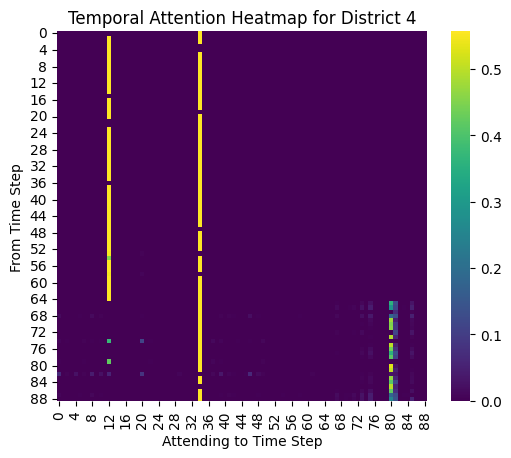

In [70]:
# Forward pass
_ = model.temporal_encoder(x_input)

# Extract attention
attn = model.temporal_encoder.attn_weights  # [batch, time, time]

# Visualize attention of a sample node
import seaborn as sns
import matplotlib.pyplot as plt

node_idx = 4
sns.heatmap(attn[node_idx].numpy(), cmap='viridis', square=True)
plt.title(f"Temporal Attention Heatmap for District {node_idx}")
plt.xlabel("Attending to Time Step")
plt.ylabel("From Time Step")
plt.show()


In [72]:
from scipy.stats import spearmanr

corr, _ = spearmanr(preds, targets)
print(f"📈 Spearman Rank Correlation: {corr:.2f}")


📈 Spearman Rank Correlation: 0.56


In [73]:
k = 5
top_k_pred = set(preds.argsort()[-k:])
top_k_actual = set(targets.argsort()[-k:])
hits = len(top_k_pred.intersection(top_k_actual))
hit_rate = hits / k

print(f"🎯 Top-{k} Hit Rate: {hit_rate:.2f}")


🎯 Top-5 Hit Rate: 0.60


# **Step 11: Quantum-Inspired Patrol Optimization**

Now that we can forecast crime risk per district, we implement a post-prediction decision layer.

We frame patrol assignment as an optimization problem:
- Select `K` districts with the highest cumulative crime risk
- Use Quantum-Behaved Particle Swarm Optimization (QPSO) to search the space of possible patrol assignments

This simulates how a smart city might deploy police units dynamically, based on learned risk forecasts.


In [75]:
import numpy as np
import random

# Predicted crime scores per district (replace with your model output)
crime_risk = np.array(preds)

# Parameters
num_districts = len(crime_risk)
num_particles = 30
num_iterations = 100
K = 5  # Number of patrols

# Each particle represents a binary vector of patrol placements
def fitness(particle):
    """Returns total predicted crime in districts selected by this particle."""
    return crime_risk[particle.astype(bool)].sum()

# Initialize particles randomly
particles = np.array([
    np.random.choice([0, 1], size=num_districts, p=[1-K/num_districts, K/num_districts])
    for _ in range(num_particles)
])

# Initialize personal and global bests
pbest = particles.copy()
pbest_scores = np.array([fitness(p) for p in pbest])
gbest_idx = pbest_scores.argmax()
gbest = pbest[gbest_idx].copy()
gbest_score = pbest_scores[gbest_idx]

# QPSO Main Loop
for iter in range(num_iterations):
    mbest = pbest.mean(axis=0)
    for i in range(num_particles):
        u = np.random.rand(num_districts)
        beta = 1.5
        direction = np.sign(np.random.rand(num_districts) - 0.5)
        step = beta * np.abs(mbest - particles[i]) * np.log(1/u)
        candidate = particles[i] + direction * step
        candidate = np.clip(candidate, 0, 1)
        candidate = (candidate > 0.5).astype(int)

        # Enforce exactly K patrols
        if candidate.sum() > K:
            top_k_idx = candidate.argsort()[::-1][:K]
            new_particle = np.zeros_like(candidate)
            new_particle[top_k_idx] = 1
        elif candidate.sum() < K:
            best_k_idx = crime_risk.argsort()[::-1][:K]
            new_particle = np.zeros_like(candidate)
            new_particle[best_k_idx] = 1
        else:
            new_particle = candidate

        # Evaluate
        f = fitness(new_particle)
        if f > pbest_scores[i]:
            pbest[i] = new_particle
            pbest_scores[i] = f

            if f > gbest_score:
                gbest = new_particle
                gbest_score = f


 Optimal Patrol Deployment (QPSO):
✅ District 0 — Predicted Risk: 0.65
✅ District 1 — Predicted Risk: 0.63
✅ District 2 — Predicted Risk: 0.99
✅ District 6 — Predicted Risk: 0.00
✅ District 10 — Predicted Risk: 0.81
✅ District 16 — Predicted Risk: 0.18
✅ District 17 — Predicted Risk: 0.54
✅ District 18 — Predicted Risk: 0.76
✅ District 22 — Predicted Risk: 0.88


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128737 (\N{SHIELD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


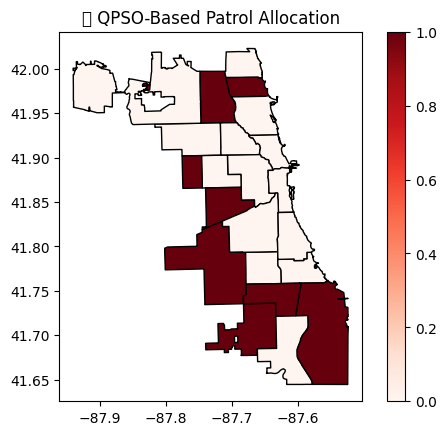

In [77]:
print(" Optimal Patrol Deployment (QPSO):")
for idx, selected in enumerate(gbest):
    if selected:
        print(f"✅ District {idx} — Predicted Risk: {crime_risk[idx]:.2f}")

# Visualize on Map
gdf['QPSO Patrol'] = gbest
gdf.plot(column='QPSO Patrol', cmap='Reds', legend=True, edgecolor='black')
plt.title("🛡️ QPSO-Based Patrol Allocation")
plt.show()
